<a href="https://colab.research.google.com/github/AnupamaRajkumar/PyTorchTutorials/blob/main/ImageRecognitionUsingMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Multi-class classification : Softmax function

In [1]:
!pip3 install torch

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

This is needed to counter the HTTP 503 error

In [3]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2021-03-21 06:29:20--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-03-21 06:29:20--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [             <=>    ]  33.20M  9.94MB/s    in 4.1s    

2021-03-21 06:29:24 (8.04 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [4]:
root_dir = './'
datasets.MNIST(root=root_dir,download=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train

In [5]:
transform = transforms.Compose([transforms.ToTensor(), 
                                #first argument specifies the mean, second argument specifies the stddev to create a range from -1 to 1
                                transforms.Normalize((0.5,), (0.5,))])
#training
training_dataset = datasets.MNIST(root=root_dir, train=True, download=True, transform=transform)
#validation
validation_dataset = datasets.MNIST(root = root_dir, train=False, download=True, transform=transform)

Training data loader

In [6]:
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)

Validation data loader

In [7]:
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False) 

Converting tensors to numpy so as to plot it\
To get numpy() from tensor, use detach() function

Why we use detach()?\
torch.tensors has an additional layer for storing the computational graph leading to associated n-dimesional matrix. torch.tensors() are designed to be used with gradient descent optimisation and they hold both the tensors with numeric values and computational graph leading to these values. The computational graph is then used to compute the derivative of the loss function wrt to each of the independent variables to compute the loss.\
np.ndarray does not have this "computational graph" and hence when converting a tensor to numpy array, detach() is used to remove this computational graph\
https://stackoverflow.com/questions/63582590/why-do-we-call-detach-before-calling-numpy-on-a-pytorch-tensor

In [8]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0) #shape 28 x 28 x 1
  #de-normalisation - multiply by std and add mean
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

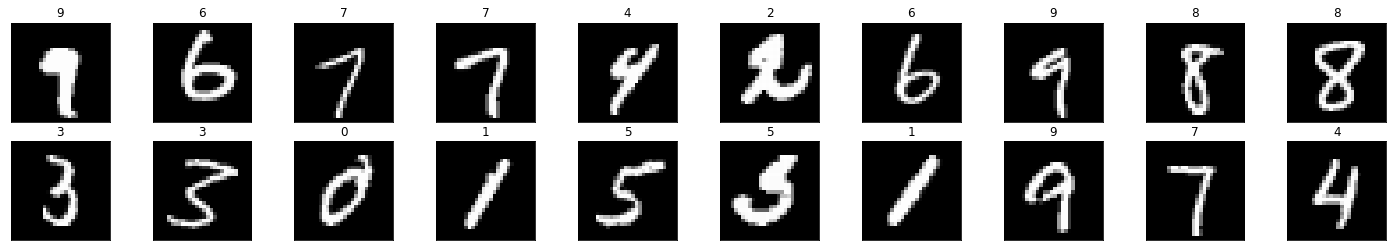

In [9]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(labels[idx].item())

nn.Sequential and nn.Module\
**nn.Module**: This is the main building block, it defines base class for all the neural network and you MUST subclass it. When using nn.Module, we must write our own forward() method. This allows us to define our own model in a functional way\
**nn.Sequential**: Sequential is a container of Modules that can be stacked together and run at the same time 



https://towardsdatascience.com/pytorch-how-and-when-to-use-module-sequential-modulelist-and-moduledict-7a54597b5f17


In [10]:
class Classifier(nn.Module):
  def __init__(self, d_in, h1, h2, d_out):
    super().__init__()
    self.linear1 = nn.Linear(d_in, h1)
    self.linear2 = nn.Linear(h1, h2)
    self.linear3 = nn.Linear(h2, d_out)

  def forward(self, x):
    H1 = F.relu(self.linear1(x))
    H2 = F.relu(self.linear2(H1))
    #we can omit softmax here since we will use crossentropy as loss criterion
    #and it's implementation in pytorch already implements softmax
    Y  = self.linear3(H2)
    return Y


In [11]:
model = Classifier(784 , 125, 65, 10) 
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
epochs = 20
losses = []
accuracy = []
val_losses = []
val_accuracies = []

for e in range(epochs):
  running_loss = 0.0
  running_accuracy = 0.0
  val_loss = 0.0
  val_accuracy = 0.0

  for images, labels in training_loader:
    #flatten the image
    images = images.view(images.shape[0], -1)    #(1, 784)
    outputs = model(images)   #forward?
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_accuracy += torch.sum(preds == labels.data)
    running_loss += loss.item() 

  else:
    with torch.no_grad():       #because we dont have to perform gradients for validation set
      for val_images, val_labels in validation_loader:
        val_images = val_images.view(val_images.shape[0], -1)
        val_outputs = model(val_images)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_accuracy += torch.sum(val_preds == val_labels.data)
        val_loss += val_loss.item() 
    #metrics for training data
    epoch_loss = running_loss/len(training_loader)
    epoch_accuracy = running_accuracy.float()/len(training_loader)
    losses.append(epoch_loss)
    accuracy.append(epoch_accuracy)
    #metrics for validation data
    val_epoch_loss = val_loss/len(validation_loader)
    val_epoch_accuracy = val_accuracy.float()/len(validation_loader)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)
    #print the training and validation metrics
    print("epoch:", e+1)
    print('training loss: {:.4f}, acc {:.4f}'.format(epoch_loss, epoch_accuracy.item()))
    print('validation loss: {:.4f}, acc {:.4f}'.format(val_epoch_loss, val_epoch_accuracy.item()))


epoch: 1
training loss: 0.4369, acc 87.2333
validation loss: 0.0081, acc 92.0500
epoch: 2
training loss: 0.2166, acc 93.5667
validation loss: 0.0057, acc 94.5500
epoch: 3
training loss: 0.1631, acc 95.0250
validation loss: 0.0037, acc 95.7400
epoch: 4
training loss: 0.1286, acc 96.1217
validation loss: 0.0045, acc 96.1900
epoch: 5
training loss: 0.1093, acc 96.6467
validation loss: 0.0036, acc 96.8200
epoch: 6
training loss: 0.0939, acc 97.1333
validation loss: 0.0018, acc 97.1100
epoch: 7
training loss: 0.0834, acc 97.4567
validation loss: 0.0023, acc 97.1300
epoch: 8
training loss: 0.0746, acc 97.6650
validation loss: 0.0017, acc 97.1100
epoch: 9
training loss: 0.0678, acc 97.8600
validation loss: 0.0046, acc 97.0900
epoch: 10
training loss: 0.0639, acc 97.9300
validation loss: 0.0024, acc 97.4800
epoch: 11
training loss: 0.0562, acc 98.1533
validation loss: 0.0027, acc 97.1400
epoch: 12
training loss: 0.0504, acc 98.3783
validation loss: 0.0027, acc 97.4400
epoch: 13
training loss: 

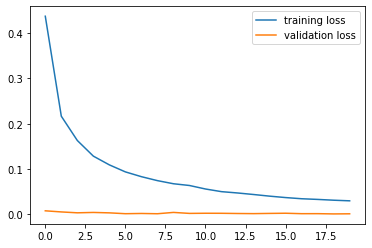

In [14]:
plt.plot(losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

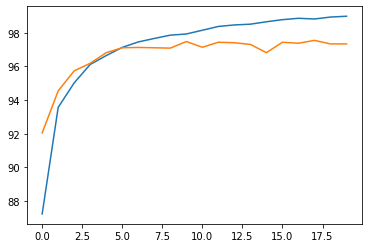

In [15]:
plt.plot(accuracy, label='training accuracy')
plt.plot(val_accuracies, label = 'validation accuracy')

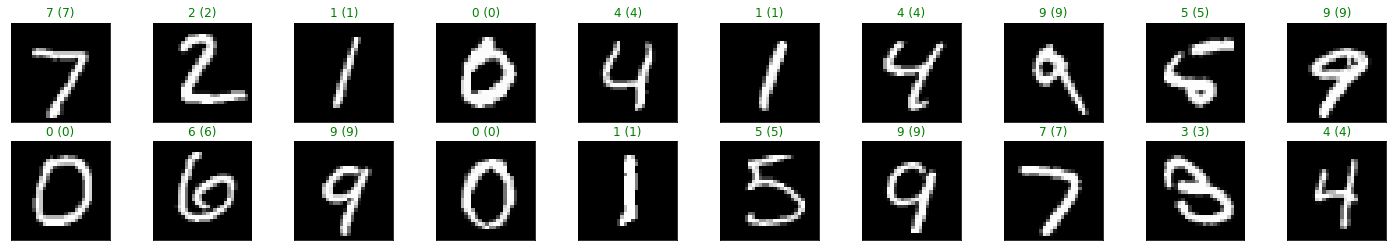

In [20]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images_ = images.view(images.shape[0], -1)
output = model(images_)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))